In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Github/

In [33]:
!git clone https://github.com/rohit-khoiwal-30/msgmt.git

Cloning into 'msgmt'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 104 (delta 67), reused 36 (delta 16), pack-reused 0
Receiving objects: 100% (104/104), 2.00 MiB | 5.89 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [18]:
%cd msgmt

/kaggle/working/msgmt


In [16]:
import pandas as pd

In [19]:
df = pd.read_csv("augment_train.csv")
df_test = pd.read_csv("evaluation.csv")

In [4]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2

try:
    import tensorflow_hub as hub
except ModuleNotFoundError:
    %pip install -q tensorflow_hub
    import tensorflow_hub as hub

try:
    import tensorflow_text as text
except ModuleNotFoundError:
    %pip install -q -U tensorflow-text
    %pip install -q tf-models-official
    import tensorflow_text as text

try:
    from keras_self_attention import SeqSelfAttention
except ModuleNotFoundError:
    %pip install -q keras-self-attention
    from keras_self_attention import SeqSelfAttention

import numpy as np
import math as m

Note: you may need to restart the kernel to use updated packages.


In [5]:
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/2"

In [6]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    text_batch, reason_batch, y_hat = [], [], []
    all_groups = list(range(in_groups[0].shape[0]))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        text_batch += [in_groups[0][c_idx] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            y_hat += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            y_hat += [0]*batch_halfsize
            
        reason_batch += [in_groups[1][c_idx] for c_idx in b_group_idx]
            
    return np.stack(text_batch, 0), np.stack(reason_batch, 0), np.stack(y_hat, 0)

def siam_gen(in_groups, batch_size = 32):
    while True:
        text_stack, reason_stack, y_hat_stack = gen_random_batch(in_groups, batch_size//2)
        yield [text_stack, reason_stack], y_hat_stack

In [7]:
def accuracy(y_true, y_pred):
    results = (y_pred >= 0.5).astype(int).squeeze()
    return np.mean([y_true == results])

In [25]:
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
bert_layer1 = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name="textEncoder")
bert_layer2 = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name="ReasonEncoder")
def encoder1(name):
    inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    
    encoder_inputs = preprocessing_layer(inputs)
    encoder_outputs = bert_layer1(encoder_inputs)
    net = encoder_outputs['pooled_output']
    a = tfl.Dropout(0.3)(net)
    a = tfl.Dense(128, activation="linear", kernel_regularizer=l2(1e-3))(a)
    a = tfl.BatchNormalization()(a)
    a = tfl.Activation('relu')(a)
    a = tfl.Dense(64, activation="linear", kernel_regularizer=l2(1e-3))(a)
    a = tfl.BatchNormalization()(a)
    a = tfl.Activation('relu')(a)
    a = tfl.Dense(32, activation="linear", kernel_regularizer=l2(1e-3))(a)
    a = tfl.BatchNormalization()(a)
    outputs = tfl.Activation('relu')(a)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

def encoder2(name):
    inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name="reason")
    
    encoder_inputs = preprocessing_layer(inputs)
    encoder_outputs = bert_layer2(encoder_inputs)
    net = encoder_outputs['pooled_output']
    a = tfl.Dropout(0.3)(net)
    a = tfl.Dense(64, activation="linear", kernel_regularizer=l2(1e-3))(a)
    a = tfl.BatchNormalization()(a)
    a = tfl.Activation('relu')(a)
    a = tfl.Dense(32, activation="linear", kernel_regularizer=l2(1e-3))(a)
    a = tfl.BatchNormalization()(a)
    outputs = tfl.Activation('relu')(a)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [26]:
def get_model():
    #textEncoder
    inputText = tf.keras.layers.Input(shape=(), dtype=tf.string)
    text_embedd = encoder1("textBertEncoder")(inputText)

    #reasonEncoder
    inputReason = tf.keras.layers.Input(shape=(), dtype=tf.string)
    reason_embedd = encoder2("reasonBertEncoder")(inputReason)

    combined_features = tfl.concatenate([text_embedd, reason_embedd], name = 'merge_features')
    print(combined_features.shape)
    combined_features = tfl.Dropout(0.2)(combined_features)
    combined_features = tfl.Dense(16, activation = 'linear', kernel_regularizer=l2(1e-3))(combined_features)
    combined_features = tfl.BatchNormalization()(combined_features)
    combined_features = tfl.Activation('relu')(combined_features)
    combined_features = tfl.Dense(4, activation = 'linear', kernel_regularizer=l2(1e-3))(combined_features)
    combined_features = tfl.BatchNormalization()(combined_features)
    combined_features = tfl.Activation('relu')(combined_features)
    combined_features = tfl.Dense(1, activation = 'sigmoid')(combined_features)
    
    model = Model(inputs = [inputText, inputReason], outputs = [combined_features], name="BertModel")
    return model

In [27]:
model = get_model()

(None, 64)


In [28]:
model.summary()

Model: "BertModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 model_4 (Functional)           (None, 32)           14373729    ['input_5[0][0]']                
                                                                                                  
 model_5 (Functional)           (None, 32)           14348513    ['input_6[0][0]']                
                                                                                          

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss = "binary_crossentropy", metrics = [tf.metrics.BinaryAccuracy()])

In [30]:
eval_df = df_test[df_test['label'] == 1]

In [31]:
loss_history = model.fit(siam_gen([df["clean_text"], df["reason"]], 128),
                         validation_data = siam_gen([eval_df["clean_text"].values, eval_df["reason"].values], 128),
                         steps_per_epoch=50, validation_steps=10, epochs = 50, 
                         verbose = True, use_multiprocessing=True)

Epoch 1/50
50/50 [==============================] - 128s 2s/step - loss: 1.3249 - binary_accuracy: 0.4980 - val_loss: 1.1667 - val_binary_accuracy: 0.5000
Epoch 2/50
50/50 [==============================] - 103s 2s/step - loss: 1.3007 - binary_accuracy: 0.5019 - val_loss: 1.2203 - val_binary_accuracy: 0.5000
Epoch 3/50
50/50 [==============================] - 102s 2s/step - loss: 1.2747 - binary_accuracy: 0.4995 - val_loss: 1.1565 - val_binary_accuracy: 0.5000
Epoch 4/50
50/50 [==============================] - 103s 2s/step - loss: 1.2542 - binary_accuracy: 0.5031 - val_loss: 1.1508 - val_binary_accuracy: 0.5000
Epoch 5/50
50/50 [==============================] - 103s 2s/step - loss: 1.2430 - binary_accuracy: 0.4925 - val_loss: 1.1977 - val_binary_accuracy: 0.5000
Epoch 6/50
50/50 [==============================] - 102s 2s/step - loss: 1.2153 - binary_accuracy: 0.4998 - val_loss: 1.2636 - val_binary_accuracy: 0.5000
Epoch 7/50
50/50 [==============================] - 103s 2s/step - los

In [32]:
from sklearn.metrics import brier_score_loss as brier_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

In [34]:
model.save('augment_models/bertCONCT/')

2022-08-21 06:49:05.434486: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [33]:
y_preds = model.predict([df['clean_text'], df['reason']])
accuracy(df['label'], y_preds)

1.0

In [35]:
y_hat = (y_preds >= 0.5).astype(int)

In [36]:
print("Brier Loss                       : ", brier_loss(df['label'], y_preds))
print("Precision Score                  : ", precision_score(df['label'], y_hat))
print("Recall Score                     : ", recall_score(df['label'], y_hat))
print("F1 Score                         : ", f1_score(df['label'], y_hat))

Brier Loss                       :  0.22901464504017033
Precision Score                  :  1.0
Recall Score                     :  1.0
F1 Score                         :  1.0


In [37]:
y_preds = model.predict([df_test['clean_text'], df_test['reason']])
accuracy(df_test['label'], y_preds)

0.33344444444444443

In [38]:
y_hat = (y_preds >= 0.5).astype(int)

In [39]:
print("Brier Loss                       : ", brier_loss(df_test['label'], y_preds))
print("Precision Score                  : ", precision_score(df_test['label'], y_hat))
print("Recall Score                     : ", recall_score(df_test['label'], y_hat))
print("F1 Score                         : ", f1_score(df_test['label'], y_hat))
print("Roc AUC Score                    : ", roc_auc_score(df_test['label'], y_preds))
print("BCE Loss                         : ", log_loss(df_test['label'], y_preds))

Brier Loss                       :  0.25760373230547745
Precision Score                  :  0.33344444444444443
Recall Score                     :  1.0
F1 Score                         :  0.5001249895842013
Roc AUC Score                    :  0.5575379968637448
BCE Loss                         :  0.708364265428649


In [42]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(df_test['label'], y_preds)
roc_auc = auc(fpr, tpr)

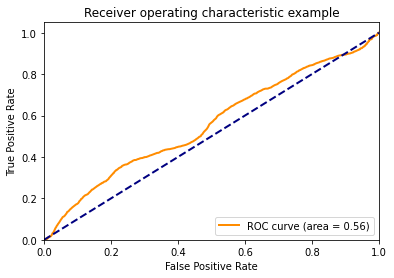

In [44]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [59]:
from numpy import asarray
from numpy import savetxt
# define data
data1 = asarray([fpr])
data2 = asarray([tpr])

# save to csv file
savetxt('roc/bertCONCT/fprdata.csv', data1, delimiter=',')
savetxt('roc/bertCONCT/tprdata.csv', data2, delimiter=',')

['fprdata.csv', 'tprdata.csv']